# Self-Supervised Learning Homework

### Author: Denys Herasymuk

This notebook includes evaluation for the resnet backbone model with random weights that is pretrained by my own.

Many parts of this notebook are a modified version of [the official MoCo code](https://github.com/facebookresearch/moco) and [the code examples of pytorch-metric-learning library](https://kevinmusgrave.github.io/pytorch-metric-learning#using-loss-functions-for-unsupervised-self-supervised-learning), which is adapted to the multilabel classification in the homework.


In [ ]:
from IPython.display import Image, HTML, clear_output
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# clear_output()

In [ ]:
# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

## Install libraries

In [ ]:
# !pip install pytorch-metric-learning[with-hooks]
# !pip install faiss-gpu
# clear_output()

In [ ]:
# !pip install albumentations
# !pip install annoy
# !pip install ml_metrics
# clear_output()

## Download dataset

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=190sY3nZk5l9XRVg3EB7qiyfYOySfmANK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=190sY3nZk5l9XRVg3EB7qiyfYOySfmANK" -O stanford_online_products.zip && rm -rf /tmp/cookies.txt

In [ ]:
# !unzip ./stanford_online_products.zip
# clear_output()

In [ ]:
# !git clone https://github.com/denysgerasymuk799/UCU_CV_Metric_Learning_HW.git

In [ ]:
# !git pull

## Import libraries

In [ ]:
import logging
import copy
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
from tqdm import tqdm

from pytorch_metric_learning import losses
from pytorch_metric_learning.utils import logging_presets

In [ ]:
repo_path = '/content/UCU_CV_Metric_Learning_HW'
if os.getcwd() != repo_path:
  os.chdir(repo_path)
  print('Current working dir: ', os.getcwd())

Current working dir:  /content/UCU_CV_Metric_Learning_HW


In [ ]:
from src.models.multilabel_classifier import MultilabelClassifier
from src.data_preparation.online_products_datasets import OnlineProductsDataset
from src.data_preparation.prepare_datasets import get_data_transforms, get_files_metadata_dfs, get_datasets, get_data_loaders
from src.models.model_types import ModelTypes
from src.models.resenet_initializer import ResNetInitializer
from src.utils.annoy_utils import get_embedding, build_index, load_index
from src.utils.viz_utils import normalized_img_tensor_to_rgb, show_img, show_retrieval
from src.utils.fine_tuning import complex_criterion, fine_tune_model, fine_tune_arcface
from src.utils.model_evaluation import evaluate

## Define configs

In [ ]:
NUM_EPOCHS = 7
SEED = 42
VAL_FRACTION = 0.2
BATCH_SIZE = 64
NUM_WORKERS = 16
MEMORY_SIZE = 1024 * 4

METRICS_K = 5
KNN_K = 200
KNN_T = 0.1
MODEL_NAME = 'resnet18_self_supervised'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INDEX_MODEL_OUTPUT_SIZE = 512  # Length of item vector that will be indexed

ROOT_DATA_DIR = '/content/Stanford_Online_Products'
GDRIVE_DATA_DIR = '/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/Metric_Learning_HW1/results'

In [ ]:
models_metrics_df = pd.DataFrame(columns=[
    'Model_Name',
    'Accuracy_Class_ID',
    'Accuracy_Superclass_ID',
    f'mAP@{METRICS_K}_Class_ID',
    f'mAP@{METRICS_K}_Superclass_ID'
])

## Create data loaders

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor


######################
### from MoCo repo ###
######################
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, image):
        q = self.base_transform(image=image)['image']
        k = self.base_transform(image=image)['image']
        return [q, k]


class OnlineProductsSelfSupervisedDataset(OnlineProductsDataset):
    def __init__(self, files_metadata_df, root_data_dir, transform=None):
        super().__init__(files_metadata_df, root_data_dir, transform)
        self.superclasses = self.files_metadata_df["super_class_id"].unique().tolist()

    def __getitem__(self, idx):
        _, class_id, superclass_id, img_path = self.files_metadata_df.iloc[idx]

        # Read an image with OpenCV
        image = self.get_image(img_path)

        if self.transform:
            augmented = self.transform(image=image)
            if len(augmented) == 1:
                augmented = augmented['image']

        return augmented, class_id, superclass_id


def get_self_supervised_datasets(files_metadata_dfs, root_data_dir):
    data_transforms = get_data_transforms()
    data_transforms['train'] = TwoCropsTransform(data_transforms['train'])

    train_dataset = OnlineProductsSelfSupervisedDataset(files_metadata_dfs['train'], root_data_dir, data_transforms['train'])
    val_dataset = OnlineProductsSelfSupervisedDataset(files_metadata_dfs['val'], root_data_dir, data_transforms['val'])
    test_dataset = OnlineProductsSelfSupervisedDataset(files_metadata_dfs['test'], root_data_dir, data_transforms['val'])
    train_dataset_for_eval = OnlineProductsSelfSupervisedDataset(files_metadata_dfs['train'], root_data_dir, data_transforms['val'])

    return {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset,
        'train_for_eval': train_dataset_for_eval,
    }


def show_img_pos_pair(dataset, idx):
    img_pos_pair, class_id, superclass_id = dataset[idx]

    for n_col, img in enumerate(img_pos_pair):
        fig = plt.figure()
        rows, cols = 1, 1
        fig.add_subplot(rows, cols, 1)
        rgb_img = normalized_img_tensor_to_rgb(img)
        plt.imshow(rgb_img)

        plt.axis('off')
        plt.title('Image')
    
    print(f'Superclass id: {superclass_id}\nClass id: {class_id}\n')


In [ ]:
files_metadata_dfs = get_files_metadata_dfs(ROOT_DATA_DIR, VAL_FRACTION, SEED)

Train shape:  (47640, 4)
Val shape:  (11911, 4)
Test shape:  (60502, 4)


In [ ]:
num_superclasses = max([len(files_metadata_dfs[phase]['super_class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of superclasses: ', num_superclasses)
num_classes = max([len(files_metadata_dfs[phase]['class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of classes: ', num_classes)

Number of superclasses:  12
Number of classes:  11318


In [ ]:
datasets = get_self_supervised_datasets(files_metadata_dfs, ROOT_DATA_DIR)
data_loaders = get_data_loaders(datasets, BATCH_SIZE, NUM_WORKERS)

Superclass id: 2
Class id: 908



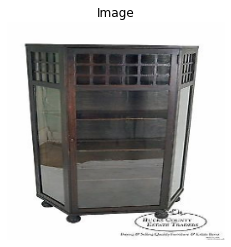

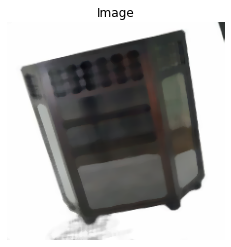

In [ ]:
show_img_pos_pair(datasets['train'], 4)

Class id: 11319
Super Class id: 1



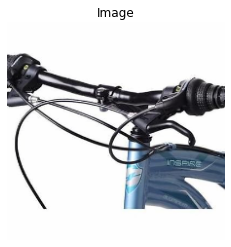

In [ ]:
show_img(datasets['test'], 4)

# Fine-tune using CrossBatchMemory from PyTorch Metric Learning 

In [ ]:
######################
### from MoCo repo ###
######################
def copy_params(encQ, encK, m=None):
    if m is None:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient
    else:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data = param_k.data * m + param_q.data * (1.0 - m)


def create_encoder(num_superclasses, num_classes):
    backbone_model = models.resnet18(pretrained=False)
    num_ftrs = backbone_model.fc.in_features
    model = MultilabelClassifier(backbone_model, num_ftrs, num_superclasses, num_classes)
    model.to(DEVICE)
    return model


######################
### from MoCo repo ###
######################
def batch_shuffle_single_gpu(x):
    """
    Batch shuffle, for making use of BatchNorm.
    """
    # random shuffle index    
    idx_shuffle = torch.randperm(x.shape[0]).to(DEVICE)

    # index for restoring
    idx_unshuffle = torch.argsort(idx_shuffle)

    return x[idx_shuffle], idx_unshuffle


######################
### from MoCo repo ###
######################
def batch_unshuffle_single_gpu(x, idx_unshuffle):
    """
    Undo batch shuffle.
    """
    return x[idx_unshuffle]


def create_labels(num_pos_pairs, previous_max_label):
    # create labels that indicate what the positive pairs are
    labels = torch.arange(0, num_pos_pairs)
    labels = torch.cat((labels, labels)).to(DEVICE)
    # add an offset so that the labels do not overlap with any labels in the memory queue
    labels += previous_max_label + 1
    # we want to enqueue the output of encK, which is the 2nd half of the batch
    enqueue_idx = torch.arange(num_pos_pairs, num_pos_pairs * 2)
    return labels, enqueue_idx


In [ ]:
######################
### from MoCo repo ###
######################
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, knn_k, knn_t, record_keeper):
    net.eval()
    classes = len(memory_data_loader.dataset.superclasses)
    total_top1, total_num, feature_bank = 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, _ in tqdm(memory_data_loader, desc="Feature extracting"):            
            feature = net(data.cuda(non_blocking=False))
            feature = torch.nn.functional.normalize(feature['superclass_id'], dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # Note that super_class_id starts from 1 in the dataset but that it starts from zero.
        # Hence, we need to subtract 1
        dataset_targets = [superclass_id - 1 for _, _, superclass_id in memory_data_loader.dataset]
        # [N]
        feature_labels = torch.tensor(
            dataset_targets, device=feature_bank.device
        )
        torch.cuda.empty_cache()

        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:            
            data, target = data.cuda(non_blocking=False), target.cuda(non_blocking=False)
            feature = net(data)
            feature = torch.nn.functional.normalize(feature['superclass_id'], dim=1)

            pred_labels = knn_predict(
                feature, feature_bank, feature_labels, classes, knn_k, knn_t
            )

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            acc = total_top1 / total_num * 100
            test_bar.set_description("Test Epoch {}: %".format(epoch))

    record_keeper.update_records(
        {"knn_monitor_accuracy": acc},
        epoch,
        parent_name="accuracy",
    )
    record_keeper.save_records()
    return acc


######################
### from MoCo repo ###
######################
# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(
        feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices
    )
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(
        feature.size(0) * knn_k, classes, device=sim_labels.device
    )
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(
        dim=-1, index=sim_labels.view(-1, 1), value=1.0
    )
    # weighted score ---> [B, C]
    pred_scores = torch.sum(
        one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1),
        dim=1,
    )

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels


In [ ]:
def train(
    encQ,
    encK,
    paramK_momentum,
    loss_fn_classes,
    loss_fn_superclasses,
    optimizer,
    train_loader,
    record_keeper,
    global_iteration,
):
    encQ.train()
    pbar = tqdm(train_loader)
    for images, *_ in pbar:
        previous_max_label_classes = torch.max(loss_fn_classes.label_memory)
        previous_max_label_superclasses = torch.max(loss_fn_superclasses.label_memory)
        imgQ = images[0].to(DEVICE)
        imgK = images[1].to(DEVICE)

        # compute output
        outputsQ = encQ(imgQ)
        encQ_out_classes = outputsQ['class_id']
        encQ_out_superclasses = outputsQ['superclass_id']
        with torch.no_grad():  # no gradient to keys
            copy_params(encQ, encK, m=paramK_momentum)
            imgK, idx_unshuffle = batch_shuffle_single_gpu(imgK)
            outputsK = encK(imgK)
            encK_out_classes = outputsK['class_id']
            encK_out_superclasses = outputsK['superclass_id']
            encK_out_classes = batch_unshuffle_single_gpu(encK_out_classes, idx_unshuffle)
            encK_out_superclasses = batch_unshuffle_single_gpu(encK_out_superclasses, idx_unshuffle)
        
        all_enc_classes = torch.cat([encQ_out_classes, encK_out_classes], dim=0)
        all_enc_superclasses = torch.cat([encQ_out_superclasses, encK_out_superclasses], dim=0)
        labels_classes, enqueue_idx_classes = create_labels(encQ_out_classes.size(0), previous_max_label_classes)
        labels_superclasses, enqueue_idx_superclasses = create_labels(encQ_out_superclasses.size(0), previous_max_label_superclasses)

        loss_classes = loss_fn_classes(all_enc_classes, labels_classes, enqueue_idx=enqueue_idx_classes)
        loss_superclasses = loss_fn_superclasses(all_enc_superclasses, labels_superclasses, enqueue_idx=enqueue_idx_superclasses)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_classes.backward(retain_graph=True)
        loss_superclasses.backward()
        optimizer.step()

        pbar.set_description(f"Loss [superclasses] = {loss_superclasses.item()};  Loss [classes] = {loss_classes.item()}")
        global_iteration["iter"] += 1


def fine_tune_self_supervised(num_superclasses, num_classes, 
                              train_dataset, val_dataset,
                              train_loader, train_for_eval_loader, val_loader,
                              knn_k, knn_t, num_epochs):
    encQ = create_encoder(num_superclasses, num_classes)
    encK = create_encoder(num_superclasses, num_classes)

    # copy params from encQ into encK
    copy_params(encQ, encK)

    model_optimizer = torch.optim.SGD(encQ.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optimizer, NUM_EPOCHS)

    ###########################################################
    ### Set the loss function and the (optional) miner here ###
    ###########################################################
    loss_fn_classes = losses.CrossBatchMemory(
        loss=losses.NTXentLoss(temperature=0.1),
        embedding_size=num_classes, # equal to the number of predicted classes
        memory_size=MEMORY_SIZE
    )
    loss_fn_superclasses = losses.CrossBatchMemory(
        loss=losses.NTXentLoss(temperature=0.1),
        embedding_size=num_superclasses, # equal to the number of predicted classes
        memory_size=MEMORY_SIZE
    )

    dataset_dict = {"train": train_dataset, "val": val_dataset}
    record_keeper, _, _ = logging_presets.get_record_keeper(
        "example_logs", "example_tensorboard"
    )
    hooks = logging_presets.get_hook_container(record_keeper)

    epoch = 0
    global_iteration = {"iter": 0}
    paramK_momentum = 0.99
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(encQ.state_dict())
    for epoch in range(1, num_epochs + 1):
        logging.info("Starting epoch {}".format(epoch))
        train(
            encQ,
            encK,
            paramK_momentum,
            loss_fn_classes,
            loss_fn_superclasses,
            model_optimizer,
            train_loader,
            record_keeper,
            global_iteration,
        )

        curr_accuracy = test(
            encQ, train_for_eval_loader, val_loader, epoch, knn_k, knn_t, record_keeper
        )
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_model_wts = copy.deepcopy(encQ.state_dict())

            checkpoint = {
                'state_dict': best_model_wts,
                'optimizer': model_optimizer.state_dict(),
            }
            torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{MODEL_NAME}_epoch_{epoch}_acc_{best_accuracy}_checkpoint.pth')
        
        scheduler.step()
        print('\n\n')
    
    # load best model weights
    encQ.load_state_dict(best_model_wts)
    return encQ, model_optimizer


### Fine-tune the model

In [ ]:
best_resnet18_self_supervised, optimizer_ft = fine_tune_self_supervised(num_superclasses, num_classes, 
                                                                        datasets['train'], datasets['val'],
                                                                        data_loaders['train'], data_loaders['train_for_eval'], data_loaders['val'],
                                                                        KNN_K, KNN_T, NUM_EPOCHS)

Loss [superclasses] = 3.492438316345215;  Loss [classes] = 3.6226682662963867: 100%|██████████| 745/745 [06:52<00:00,  1.81it/s]
Test Epoch 1: %: 100%|██████████| 187/187 [00:52<00:00,  3.56it/s]


Loss [superclasses] = 2.601003646850586;  Loss [classes] = 2.7793986797332764: 100%|██████████| 745/745 [06:37<00:00,  1.87it/s]
Test Epoch 2: %: 100%|██████████| 187/187 [00:51<00:00,  3.60it/s]


Loss [superclasses] = 2.529430866241455;  Loss [classes] = 2.206002950668335: 100%|██████████| 745/745 [06:33<00:00,  1.89it/s]
Test Epoch 3: %: 100%|██████████| 187/187 [00:51<00:00,  3.60it/s]


Loss [superclasses] = 2.2904305458068848;  Loss [classes] = 1.9714425802230835: 100%|██████████| 745/745 [06:37<00:00,  1.87it/s]
Test Epoch 4: %: 100%|██████████| 187/187 [00:51<00:00,  3.61it/s]


Loss [superclasses] = 2.1788182258605957;  Loss [classes] = 1.7902286052703857: 100%|██████████| 745/745 [06:31<00:00,  1.90it/s]
Test Epoch 5: %: 100%|██████████| 187/187 [00:53<00:00,  3.48it/s]


Loss [superclasses] = 2.2427659034729004;  Loss [classes] = 1.7205286026000977: 100%|██████████| 745/745 [06:32<00:00,  1.90it/s]
Test Epoch 6: %: 100%|██████████| 187/187 [00:53<00:00,  3.48it/s]


Loss [superclasses] = 2.2641143798828125;  Loss [classes] = 1.6676185131072998: 100%|██████████| 745/745 [06:32<00:00,  1.90it/s]
Test Epoch 7: %: 100%|██████████| 187/187 [00:52<00:00,  3.58it/s]

In [ ]:
# Set model to evaluation mode
best_resnet18_self_supervised.eval()

checkpoint = {
    'state_dict': best_resnet18_self_supervised.state_dict(),
    'optimizer': optimizer_ft.state_dict(),
}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{MODEL_NAME}_fine_tuned_checkpoint.pth')

### Build an Index

In [ ]:
annoy_index = build_index(best_resnet18_self_supervised, datasets['train_for_eval'], INDEX_MODEL_OUTPUT_SIZE,
                          MODEL_NAME, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [08:14<00:00, 96.37it/s] 



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 27223, 30371, 33183, 19186]

### Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
best_resnet18_self_supervised = create_encoder(num_superclasses, num_classes)
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{MODEL_NAME}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_resnet18_self_supervised.load_state_dict(last_checkpoint['state_dict'])
best_resnet18_self_supervised.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, MODEL_NAME, datasets['train_for_eval'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_resnet18_self_supervised, MODEL_NAME, models_metrics_df,
                             datasets['train_for_eval'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [05:55<00:00, 33.47it/s]




[resnet18_self_supervised] Accuracy for class_id: 0.231
[resnet18_self_supervised] Accuracy for superclass_id: 0.3993
[resnet18_self_supervised] mAP@5 for class_id: 0.2603
[resnet18_self_supervised] mAP@5 for superclass_id: 0.4998


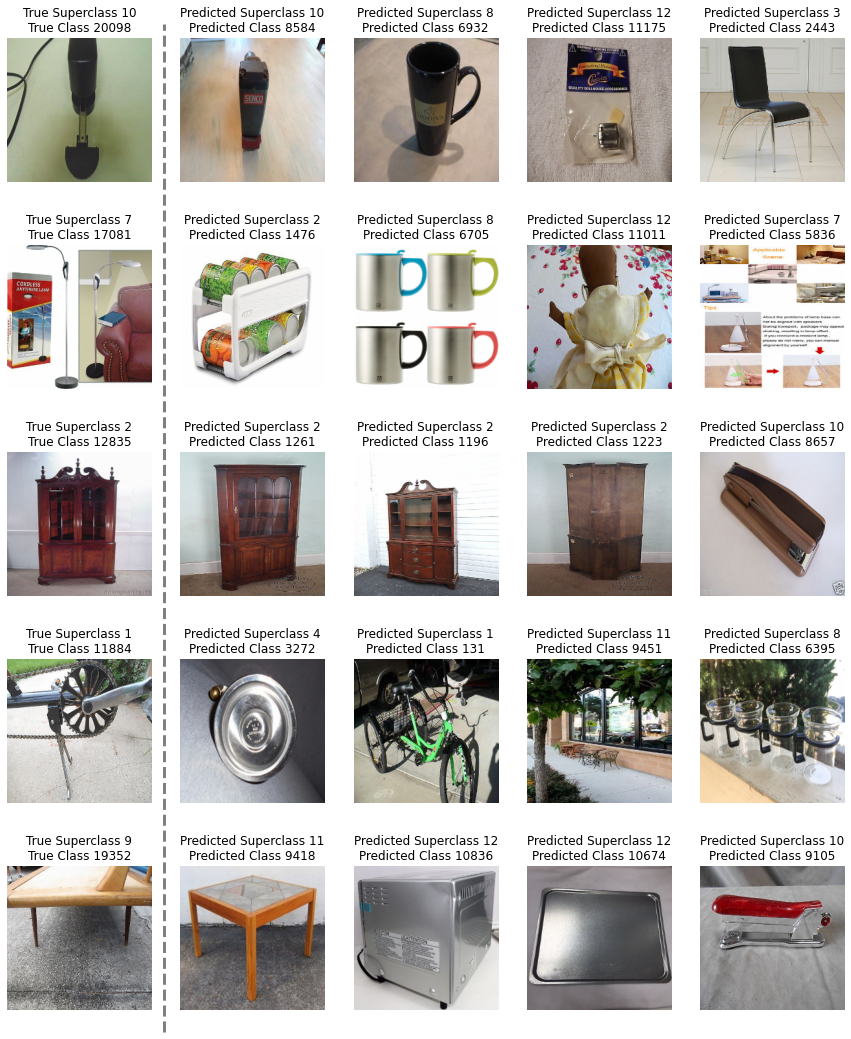

In [ ]:
show_retrieval(best_resnet18_self_supervised, annoy_index, datasets['train_for_eval'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_self_supervised,0.231,0.3993,0.2603,0.4998


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{MODEL_NAME}_models_metrics_df.csv', index=False)

# Compare results of all models 

In [ ]:
import os
import pandas as pd

GDRIVE_DATA_DIR = '/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/Metric_Learning_HW1/results'
filenames_with_metrics = []
for filename in os.listdir(GDRIVE_DATA_DIR):
    if 'metrics' in filename and 'all_' not in filename and filename[-4:] == '.csv':
        filenames_with_metrics.append(filename)

In [ ]:
all_models_metrics_df = pd.DataFrame()
for filename in filenames_with_metrics:
    model_metrics_df = pd.read_csv(f'{GDRIVE_DATA_DIR}/{filename}')
    all_models_metrics_df = pd.concat([all_models_metrics_df, model_metrics_df])

In [ ]:
all_models_metrics_df = all_models_metrics_df.sort_values(by='mAP@5_Superclass_ID', ascending=False).reset_index(drop=True)
all_models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_with_cross_entropy_loss,0.3870,0.8213,0.4214,0.8600
1,resnet18_siamese_with_contrastive_loss,0.3842,0.7879,0.4166,0.8342
2,resnet18_siamese_with_custom_contrastive_loss,0.3838,0.7812,0.4156,0.8306
3,resnet18_with_triplet_loss,0.3317,0.7687,0.3616,0.8198
4,resnet18_fine_tuned_self_supervised,0.4175,0.7302,0.4461,0.7890
5,resnet18_with_arcface_loss,0.1710,0.7333,0.1962,0.7861
6,resnet18_self_supervised,0.2310,0.3993,0.2603,0.4998
7,plain_resnet18,0.0301,0.2178,0.0342,0.3345


In [ ]:
all_models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/all_models_metrics.csv', index=False)